In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
import numpy as np

# --- 1. Load the Final Feature Dataset ---
print("Loading the final feature dataset...")

input_path = "../data/processed/final_feature_dataset.parquet"
df_features = pd.read_parquet(input_path)

print(f"Successfully loaded {len(df_features)} matches.")

Loading the final feature dataset...
Successfully loaded 989 matches.


In [7]:
features = [
    'pi_prob_h', 'pi_prob_d', 'pi_prob_a',
    'market_prob_h', 'market_prob_d', 'market_prob_a',
    'form_xg_for_home', 'form_xg_against_home',
    'form_xg_for_away', 'form_xg_against_away'
]

X = df_features[features]

# Our two target variables for goal prediction
y_home = df_features['goals_home']
y_away = df_features['goals_away']

# Split the data into training and testing sets
X_train, X_test, y_home_train, y_home_test, y_away_train, y_away_test = train_test_split(
    X, y_home, y_away, test_size=0.2, random_state=42
)

print("\nData successfully prepared for goal prediction modeling.")


Data successfully prepared for goal prediction modeling.


In [8]:
print("Training the model to predict home goals...")
home_goals_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    seed=42
)
home_goals_model.fit(X_train, y_home_train)
print("Home goals model trained successfully.")

print("\nTraining the model to predict away goals...")
away_goals_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    seed=42
)
away_goals_model.fit(X_train, y_away_train)
print("Away goals model trained successfully.")

print("\n--- Model Performance Evaluation ---")

y_home_pred = home_goals_model.predict(X_test)
y_away_pred = away_goals_model.predict(X_test)

mae_home = mean_absolute_error(y_home_test, y_home_pred)
rmse_home = np.sqrt(mean_squared_error(y_home_test, y_home_pred))

mae_away = mean_absolute_error(y_away_test, y_away_pred)
rmse_away = np.sqrt(mean_squared_error(y_away_test, y_away_pred))

print(f"\nHome Goals Model:")
print(f"  Mean Absolute Error (MAE): {mae_home:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_home:.4f}")

print(f"\nAway Goals Model:")
print(f"  Mean Absolute Error (MAE): {mae_away:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_away:.4f}")

Training the model to predict home goals...
Home goals model trained successfully.

Training the model to predict away goals...
Away goals model trained successfully.

--- Model Performance Evaluation ---

Home Goals Model:
  Mean Absolute Error (MAE): 1.1674
  Root Mean Squared Error (RMSE): 1.4567

Away Goals Model:
  Mean Absolute Error (MAE): 0.9586
  Root Mean Squared Error (RMSE): 1.2126


--- Generating Correct Score Grid for a Sample Match ---
Predicted Expected Goals -> Home: 1.22, Away: 2.45


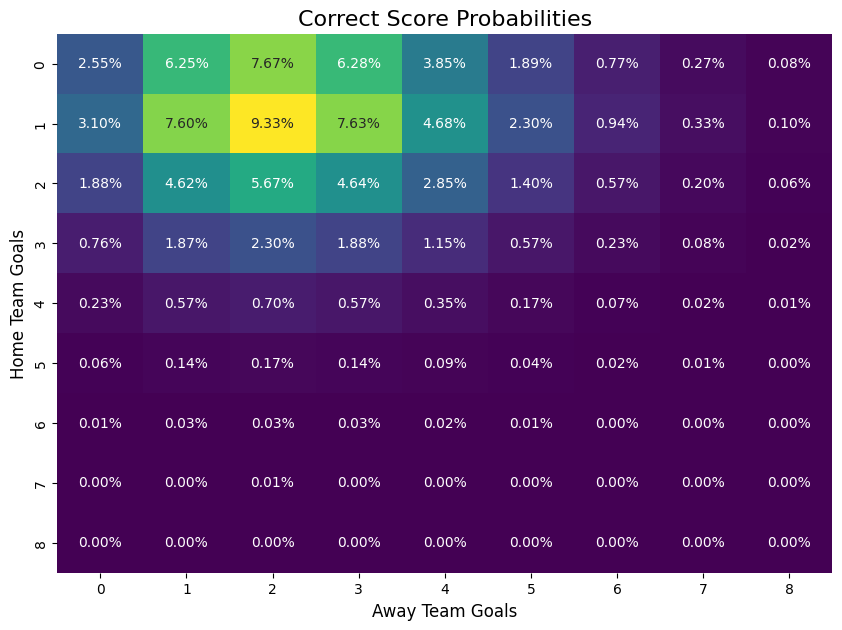

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import poisson
import seaborn as sns

def predict_score_grid(home_model, away_model, features_df):
    expected_home_goals = home_model.predict(features_df)[0]
    expected_away_goals = away_model.predict(features_df)[0]
    
    print(f"Predicted Expected Goals -> Home: {expected_home_goals:.2f}, Away: {expected_away_goals:.2f}")

    max_goals = 8
    home_goal_probs = poisson.pmf(range(max_goals + 1), expected_home_goals)
    away_goal_probs = poisson.pmf(range(max_goals + 1), expected_away_goals)

    score_grid = np.outer(home_goal_probs, away_goal_probs)
    
    return score_grid

print("--- Generating Correct Score Grid for a Sample Match ---")

sample_match_features = X_test.iloc[[0]] 

probability_grid = predict_score_grid(home_goals_model, away_goals_model, sample_match_features)

plt.figure(figsize=(10, 7))
sns.heatmap(probability_grid, annot=True, fmt=".2%", cmap="viridis", cbar=False)
plt.xlabel("Away Team Goals", fontsize=12)
plt.ylabel("Home Team Goals", fontsize=12)
plt.title("Correct Score Probabilities", fontsize=16)
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV
import numpy as np

print("--- Starting Extensive Hyperparameter Search for Home Goals Model ---")
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.1, 0.05, 0.01],
    'gamma': [0, 0.1]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', seed=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_home_train)

best_params = grid_search.best_params_
print(f"\nHyperparameter tuning complete.")
print(f"Best parameters found: {best_params}")


print("\nTraining final home and away models with optimal parameters...")
final_home_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42, **best_params)
final_home_model.fit(X_train, y_home_train)

final_away_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42, **best_params)
final_away_model.fit(X_train, y_away_train)
print("Final models trained.")

print("\n--- Final Model Performance Evaluation ---")
y_home_pred = final_home_model.predict(X_test)
y_away_pred = final_away_model.predict(X_test)

mae_home = mean_absolute_error(y_home_test, y_home_pred)
rmse_home = np.sqrt(mean_squared_error(y_home_test, y_home_pred))
mae_away = mean_absolute_error(y_away_test, y_away_pred)
rmse_away = np.sqrt(mean_squared_error(y_away_test, y_away_pred))

print(f"\nFinal Home Goals Model:")
print(f"  Mean Absolute Error (MAE): {mae_home:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_home:.4f}")
print(f"\nFinal Away Goals Model:")
print(f"  Mean Absolute Error (MAE): {mae_away:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_away:.4f}")

--- Starting Extensive Hyperparameter Search for Home Goals Model ---
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Hyperparameter tuning complete.
Best parameters found: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}

Training final home and away models with optimal parameters...
Final models trained.

--- Final Model Performance Evaluation ---

Final Home Goals Model:
  Mean Absolute Error (MAE): 1.0271
  Root Mean Squared Error (RMSE): 1.3151

Final Away Goals Model:
  Mean Absolute Error (MAE): 0.8897
  Root Mean Squared Error (RMSE): 1.1017


--- Visual Evaluation of Final Goal Models ---


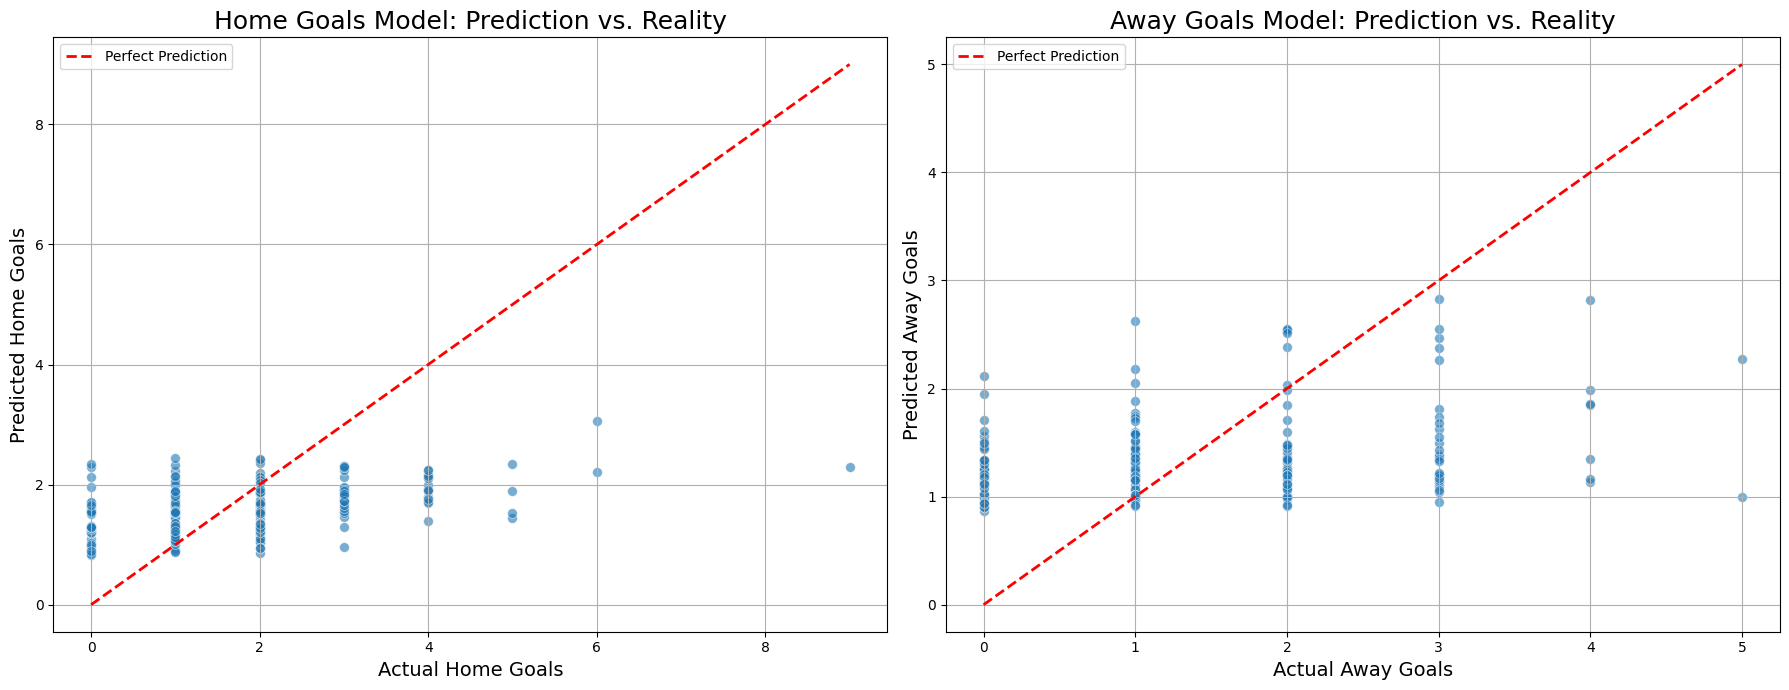

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Visual Evaluation of Final Goal Models ---")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.scatterplot(x=y_home_test, y=y_home_pred, ax=axes[0], alpha=0.6, s=50)
axes[0].plot([0, y_home_test.max()], [0, y_home_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel("Actual Home Goals", fontsize=14)
axes[0].set_ylabel("Predicted Home Goals", fontsize=14)
axes[0].set_title("Home Goals Model: Prediction vs. Reality", fontsize=18)
axes[0].legend()
axes[0].grid(True)

sns.scatterplot(x=y_away_test, y=y_away_pred, ax=axes[1], alpha=0.6, s=50)
axes[1].plot([0, y_away_test.max()], [0, y_away_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel("Actual Away Goals", fontsize=14)
axes[1].set_ylabel("Predicted Away Goals", fontsize=14)
axes[1].set_title("Away Goals Model: Prediction vs. Reality", fontsize=18)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()